In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import numpy as np
import os

# === CONFIG ===
input_path = "data/hourly_demand_partitioned/final"
forecast_steps = 24  # Forecast next 24 hours
output_dir = "data/forecast_results"
os.makedirs(output_dir, exist_ok=True)

# === LOAD DATA ===
hourly_demand = pd.read_parquet(input_path)
hourly_demand = hourly_demand.sort_values('date_hour')

# Convert hourly data to daily totals
daily_demand = hourly_demand.groupby(hourly_demand['date_hour'].dt.date)['rides'].sum()
daily_demand.index = pd.to_datetime(daily_demand.index)
daily_demand = daily_demand.asfreq('D')  # Ensure daily frequency

daily_demand = daily_demand.interpolate(method='linear')

<Axes: title={'center': 'Daily Demand'}, xlabel='date_hour'>

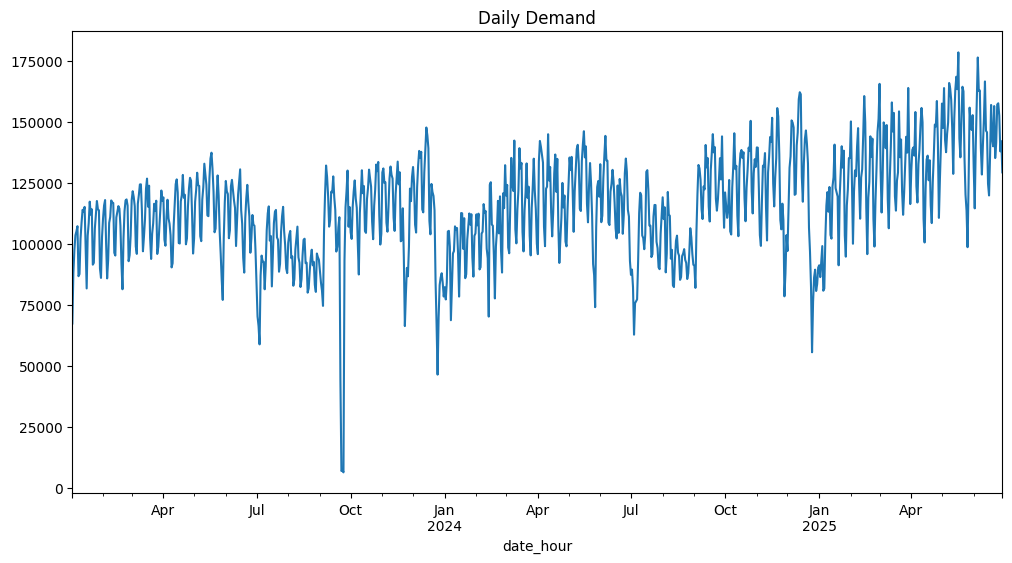

In [2]:
daily_demand.plot(figsize=(12,6), title='Daily Demand')

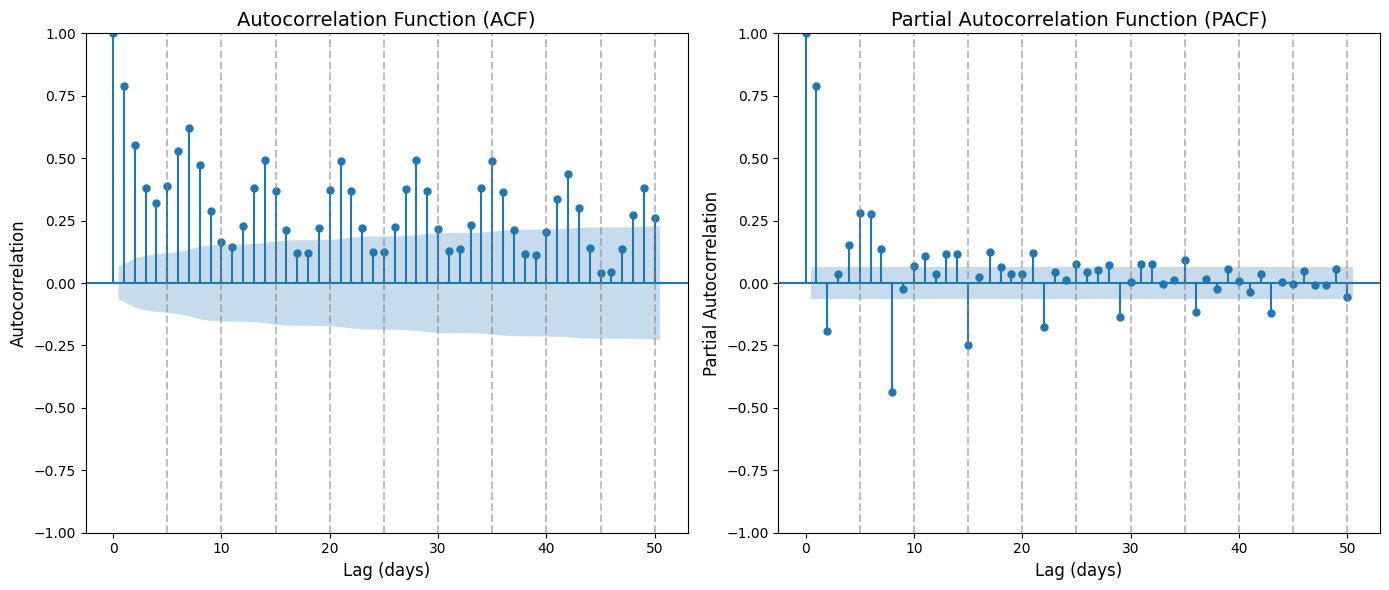

In [3]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Extract the daily series
rides_series = daily_demand

# Set up the figure for ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot Autocorrelation Function (ACF)
plot_acf(rides_series, ax=axes[0], lags=50)
axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)
axes[0].set_xlabel('Lag (days)', fontsize=12)
axes[0].set_ylabel('Autocorrelation', fontsize=12)

# Add vertical lines every 5 lags
for lag in range(5, 51, 5):
    axes[0].axvline(x=lag, color='gray', linestyle='--', alpha=0.5)

# Plot Partial Autocorrelation Function (PACF)
plot_pacf(rides_series, ax=axes[1], lags=50, method='ywm')
axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
axes[1].set_xlabel('Lag (days)', fontsize=12)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=12)

# Add vertical lines every 5 lags
for lag in range(5, 51, 5):
    axes[1].axvline(x=lag, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

The ACF and PACF plots indicate strong autocorrelation and non-stationarity, requiring first-order differencing. PACF suggests an AR(1) component, while ACF’s gradual decay points to including one or two MA terms, making ARIMA(1,1,1) or ARIMA(1,1,2) good starting models. Additionally, repeated ACF peaks every seven lags imply weekly seasonality, so SARIMA(1,1,1)(1,0,1,7) should be tested. The next step is to compare these models using AIC/BIC and validate performance on the test set.


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def print_forecast_metrics(test_df, forecast_df):
    """
    Compute and print evaluation metrics for Prophet forecast.
    
    Parameters:
    - test_df: DataFrame with actual values (columns: 'ds', 'y')
    - forecast_df: DataFrame with forecasted values (columns: 'ds', 'yhat')
    """
    # Align forecast with test dates
    forecast_test = forecast_df[forecast_df['ds'].isin(test_df['ds'])]
    
    # Extract actual and predicted values
    y_true = test_df['y'].values
    y_pred = forecast_test['yhat'].values
    
    # Compute metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Print results
    print("Forecast Evaluation Metrics:")
    print(f"  MAE :  {mae:.2f}")
    print(f"  RMSE:  {rmse:.2f}")
    print(f"  MAPE:  {mape:.2f}%")

In [5]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train/Test split
train_size = int(len(daily_demand) * 0.9)
train, test = daily_demand[:train_size], daily_demand[train_size:]

print(f"Train size: {len(train)}, Test size: {len(test)}")

# Fit SARIMA with weekly seasonality
model = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(1,1,1,7),  # Weekly seasonality
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

Train size: 819, Test size: 91
                                     SARIMAX Results                                     
Dep. Variable:                             rides   No. Observations:                  819
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -8525.882
Date:                           Sun, 16 Nov 2025   AIC                          17061.764
Time:                                   22:34:26   BIC                          17085.199
Sample:                               01-02-2023   HQIC                         17070.765
                                    - 03-30-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8617      0.017     49.592      0.000       0.828       0.896
ma.L1       

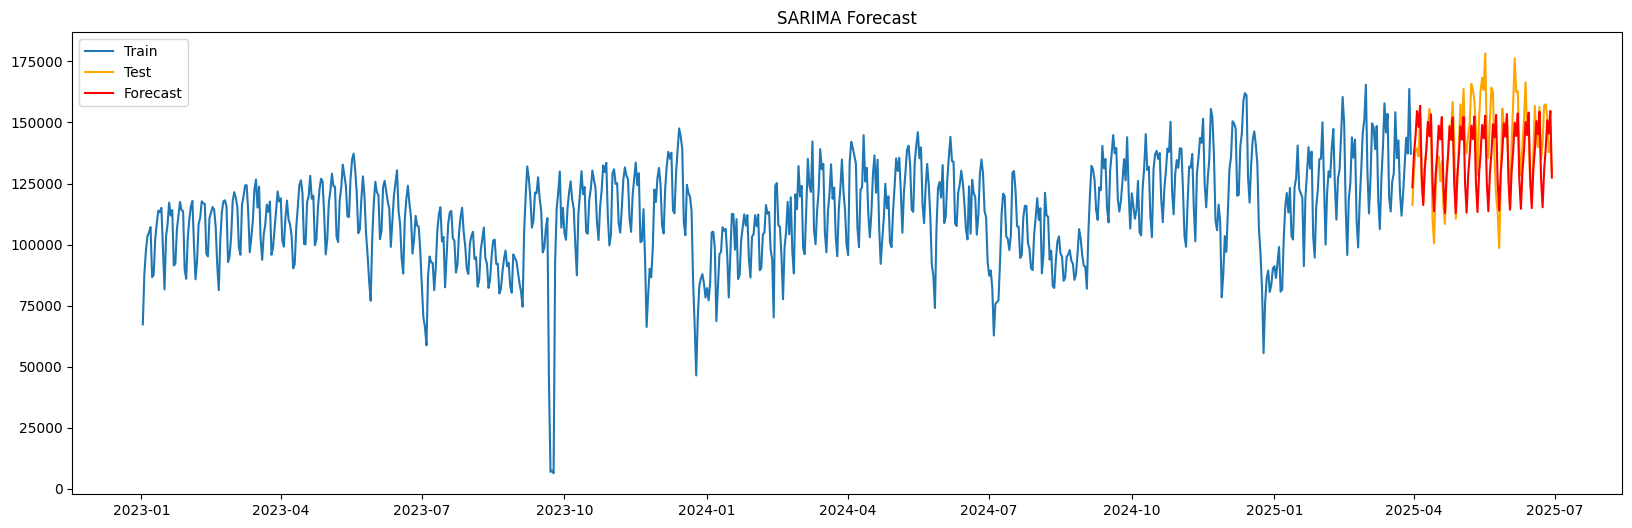

MAE:  11125.95
RMSE: 13720.65
MAPE: 7.78%


In [6]:
# Forecast for test period
forecast = results.get_forecast(steps=len(test))
forecast_ci = forecast.conf_int()

# Plot train, test, and forecast
plt.figure(figsize=(20, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
# Uncomment to show confidence intervals
# plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# Define evaluation metrics function
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def print_forecast_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

# Call the function
print_forecast_metrics(test, forecast.predicted_mean)

The SARIMA model shows reasonable accuracy:

*   **MAPE of 7.78%** indicates the forecast error is relatively low compared to actual demand, which is good for planning purposes.
*   However, **RMSE of 13,720 rides** suggests large absolute deviations on high-demand days, so the model may need refinement or additional seasonal components for better precision.



Train size: 819, Test size: 91
Fitting Auto ARIMA model...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=17883.004, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=17625.738, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=17719.622, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=17881.038, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=17879.608, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=17571.019, Time=0.25 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=17472.046, Time=1.14 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=17305.119, Time=0.80 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=17718.821, Time=0.08 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=17666.031, Time=0.18 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=173

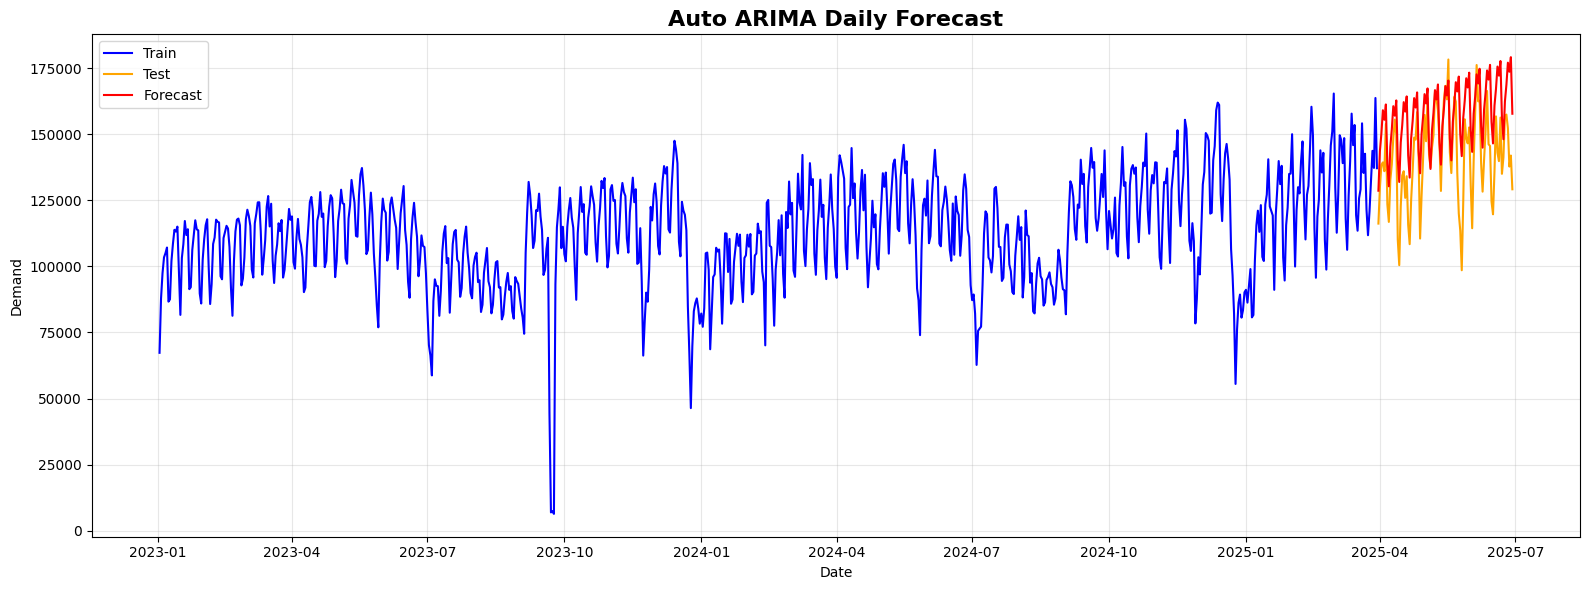


Evaluation Metrics:
  MAE :  16459.06
  RMSE:  19943.30
  MAPE:  12.49%

✅ Forecast saved to data/forecast_results/daily_forecast_auto_arima.csv
✅ Metrics saved to data/forecast_results/forecast_metrics.csv


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === CONFIG ===
INPUT_PATH = "data/hourly_demand_partitioned/final"
FORECAST_STEPS = 30  # Forecast next 30 days
OUTPUT_DIR = "data/forecast_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === LOAD DATA ===
hourly_demand = pd.read_parquet(INPUT_PATH).sort_values('date_hour')
hourly_demand['date_hour'] = pd.to_datetime(hourly_demand['date_hour'])

# === Aggregate to Daily ===
daily_demand = hourly_demand.groupby(hourly_demand['date_hour'].dt.date)['rides'].sum()
daily_demand.index = pd.to_datetime(daily_demand.index)
ts = daily_demand.asfreq('D').interpolate(method='linear')

# === Train/Test Split ===
train_size = int(len(ts) * 0.9)
train, test = ts[:train_size], ts[train_size:]
print(f"Train size: {len(train)}, Test size: {len(test)}")

# === Auto ARIMA Model ===
print("Fitting Auto ARIMA model...")
auto_model = auto_arima(train,
                        seasonal=True,
                        m=7,  # weekly seasonality
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

print(auto_model.summary())

# === Forecast ===
forecast = auto_model.predict(n_periods=len(test))
forecast_index = test.index

# === Plot Forecast ===
plt.figure(figsize=(16, 6))
plt.plot(train, label='Train', color='blue')
plt.plot(test, label='Test', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('Auto ARIMA Daily Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === Metrics Function ===
def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print("\nEvaluation Metrics:")
    print(f"  MAE :  {mae:.2f}")
    print(f"  RMSE:  {rmse:.2f}")
    print(f"  MAPE:  {mape:.2f}%")
    return {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# === Compute & Print Metrics ===
metrics = print_metrics(test, forecast)

# === Save Forecast & Metrics ===
forecast_df = pd.DataFrame({'date': forecast_index, 'forecast': forecast})
forecast_df.to_csv(os.path.join(OUTPUT_DIR, 'daily_forecast_auto_arima.csv'), index=False)

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'forecast_metrics.csv'), index=False)

print(f"\n✅ Forecast saved to {OUTPUT_DIR}/daily_forecast_auto_arima.csv")
print(f"✅ Metrics saved to {OUTPUT_DIR}/forecast_metrics.csv")

The Auto AIRMA search to minimize the **AIC (Akaike Information Criterion)**, which measures model quality (lower is better). From the results, models like **ARIMA(1,1,0)(1,0,1)\[7]** and **ARIMA(0,1,0)(1,0,1)\[7]** have significantly lower AIC values (\~17302–17305) compared to simpler models (AIC >17600), indicating that incorporating seasonal terms improves performance. Models returning **AIC=inf** failed to converge or were not suitable for the data.

The Auto ARIMA model produced a **MAPE of 12.49%**, indicating moderate forecast accuracy but room for improvement. The high **RMSE of 19,943 rides** suggests significant errors on peak-demand days.
Rather than fine tunning I will try Prophet.


## Prophet

c:\Users\moreda\venv\uplift\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
22:34:51 - cmdstanpy - INFO - Chain [1] start processing
22:34:51 - cmdstanpy - INFO - Chain [1] done processing



Evaluation Metrics:
  MAE :  10171.93
  RMSE:  12282.10
  MAPE:  7.08%


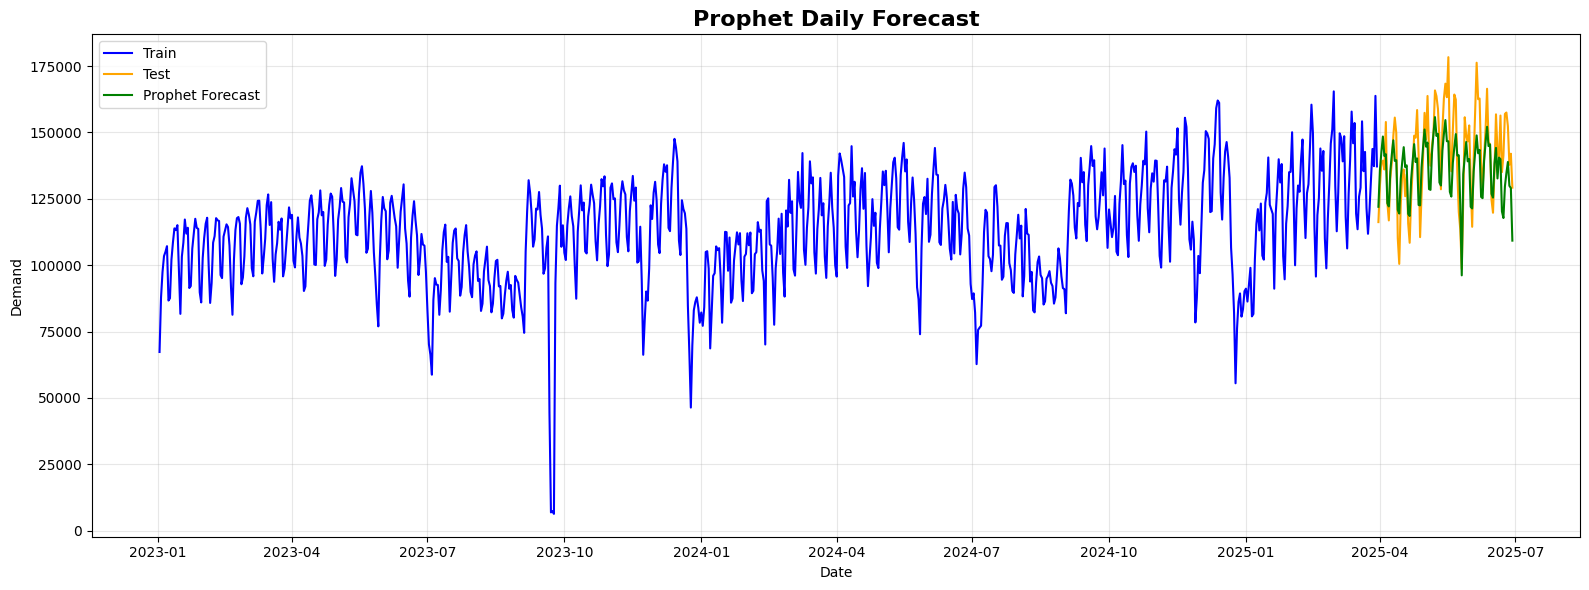

In [8]:
import pandas as pd
from prophet import Prophet
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Prepare data for Prophet
df = ts.reset_index()
df.columns = ['ds', 'y']  # Prophet requires these column names

# Train/Test split
train_size = int(len(df) * 0.9)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Create US holidays DataFrame
years = df['ds'].dt.year.unique()
us_holidays = holidays.US(years=years)
holiday_df = pd.DataFrame({
    'ds': pd.to_datetime(list(us_holidays.keys())),
    'holiday': list(us_holidays.values())
})

# Initialize Prophet model
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    holidays=holiday_df
)

# Fit model
model.fit(train_df)

# Create future dataframe (test period + extra forecast)
future = model.make_future_dataframe(periods=len(test_df) + 30, freq='D')
forecast = model.predict(future)

# Extract predictions for test period
forecast_test = forecast.iloc[-(len(test_df) + 30):-30]  # last test period
y_pred = forecast_test['yhat'].values
y_true = test_df['y'].values

# Compute metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nEvaluation Metrics:")
print(f"  MAE :  {mae:.2f}")
print(f"  RMSE:  {rmse:.2f}")
print(f"  MAPE:  {mape:.2f}%")

# Plot actual vs forecast
plt.figure(figsize=(16, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train', color='blue')
plt.plot(test_df['ds'], test_df['y'], label='Test', color='orange')
plt.plot(forecast_test['ds'], y_pred, label='Prophet Forecast', color='green')
plt.title('Prophet Daily Forecast', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The Prophet model performed well, achieving a **MAPE of 7.08%**, which indicates strong accuracy and reliable predictions for daily demand. The relatively low **RMSE of 12,282 rides** suggests that the model handles peak variations better than ARIMA, making it suitable for operational planning and forecasting.

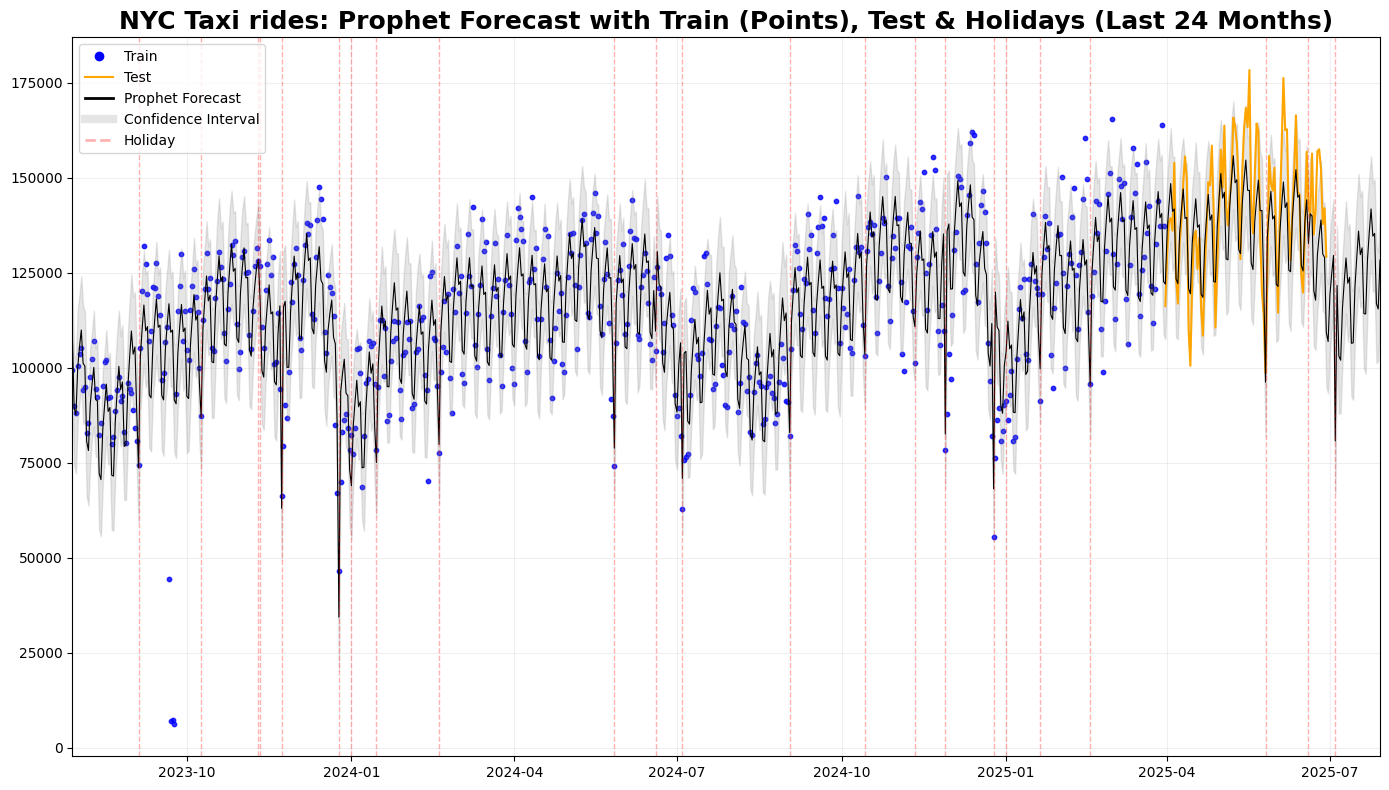

In [9]:
# Define n months
n_months = 24
end_date = forecast['ds'].max()
start_date = end_date - pd.DateOffset(months=n_months)

# Filter all data to last n months
train_zoom = train_df[(train_df['ds'] >= start_date) & (train_df['ds'] <= end_date)]
test_zoom = test_df[(test_df['ds'] >= start_date) & (test_df['ds'] <= end_date)]
forecast_zoom = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
holidays_zoom = holiday_df[(holiday_df['ds'] >= start_date) & (holiday_df['ds'] <= end_date)]

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(train_zoom['ds'], train_zoom['y'], color='blue', s=10, label='Train', alpha=0.8)
ax.plot(test_zoom['ds'], test_zoom['y'], color='orange', linewidth=1.5, label='Test')
ax.plot(forecast_zoom['ds'], forecast_zoom['yhat'], color='black', linewidth=0.8, label='Prophet Forecast')
ax.fill_between(forecast_zoom['ds'], forecast_zoom['yhat_lower'], forecast_zoom['yhat_upper'],
                color='gray', alpha=0.2, label='Confidence Interval')

# Holidays
for holiday_date in holidays_zoom['ds']:
    ax.axvline(x=holiday_date, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', marker='o', lw=0, label='Train'),
    Line2D([0], [0], color='orange', lw=1.5, label='Test'),
    Line2D([0], [0], color='black', lw=2, label='Prophet Forecast'),
    Line2D([0], [0], color='gray', lw=6, alpha=0.2, label='Confidence Interval'),
    Line2D([0], [0], color='red', linestyle='--', lw=2, alpha=0.3, label='Holiday')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True)

ax.set_xlim([start_date, end_date])
ax.set_title(f'NYC Taxi rides: Prophet Forecast with Train (Points), Test & Holidays (Last {n_months} Months)', fontsize=18, fontweight='bold')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()

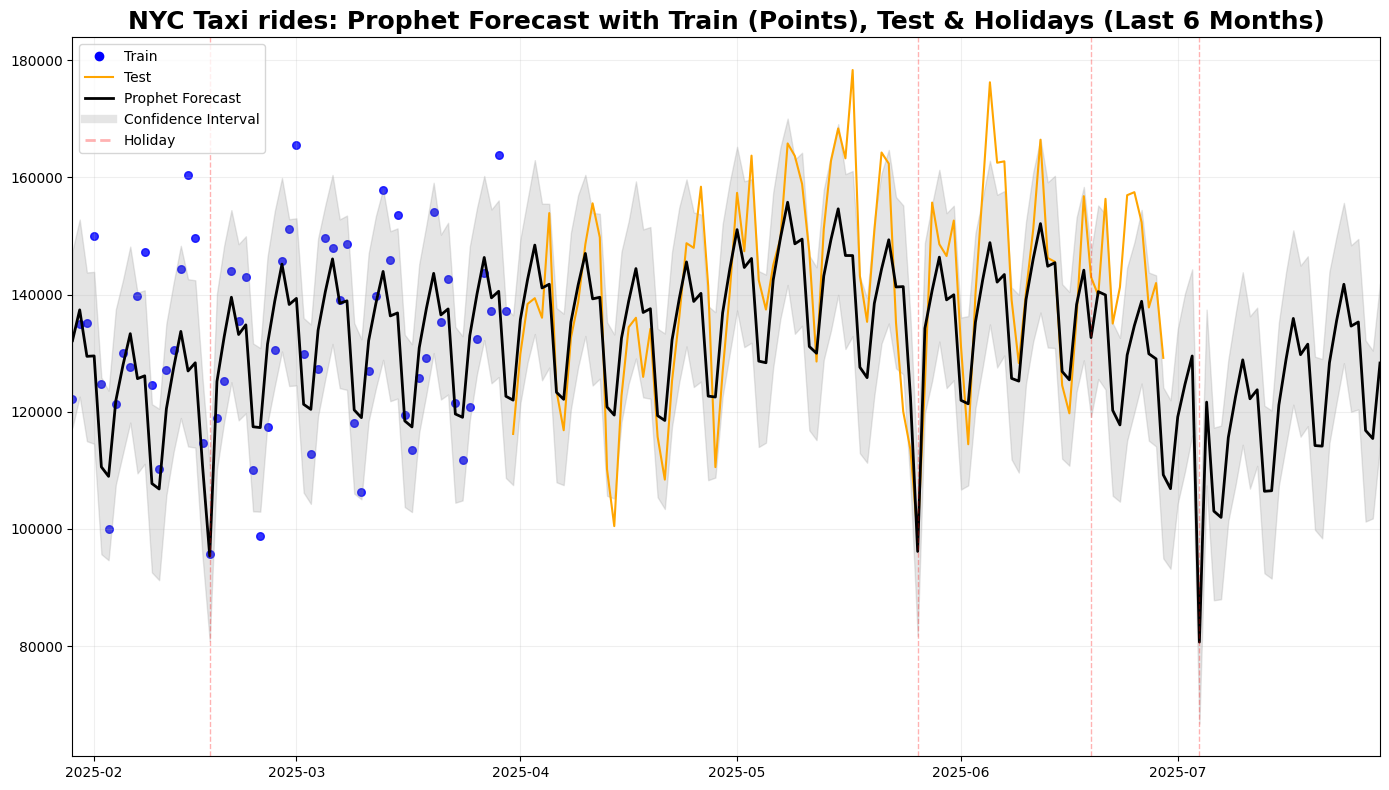

In [10]:
# Define n months
n_months = 6
end_date = forecast['ds'].max()
start_date = end_date - pd.DateOffset(months=n_months)

# Filter all data to last n months
train_zoom = train_df[(train_df['ds'] >= start_date) & (train_df['ds'] <= end_date)]
test_zoom = test_df[(test_df['ds'] >= start_date) & (test_df['ds'] <= end_date)]
forecast_zoom = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]
holidays_zoom = holiday_df[(holiday_df['ds'] >= start_date) & (holiday_df['ds'] <= end_date)]

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(train_zoom['ds'], train_zoom['y'], color='blue', s=30, label='Train', alpha=0.8)
ax.plot(test_zoom['ds'], test_zoom['y'], color='orange', linewidth=1.5, label='Test')
ax.plot(forecast_zoom['ds'], forecast_zoom['yhat'], color='black', linewidth=2, label='Prophet Forecast')
ax.fill_between(forecast_zoom['ds'], forecast_zoom['yhat_lower'], forecast_zoom['yhat_upper'],
                color='gray', alpha=0.2, label='Confidence Interval')

# Holidays
for holiday_date in holidays_zoom['ds']:
    ax.axvline(x=holiday_date, color='red', linestyle='--', alpha=0.3, linewidth=1)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', marker='o', lw=0, label='Train'),
    Line2D([0], [0], color='orange', lw=1.5, label='Test'),
    Line2D([0], [0], color='black', lw=2, label='Prophet Forecast'),
    Line2D([0], [0], color='gray', lw=6, alpha=0.2, label='Confidence Interval'),
    Line2D([0], [0], color='red', linestyle='--', lw=2, alpha=0.3, label='Holiday')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True)

ax.set_xlim([start_date, end_date])
ax.set_title(f'NYC Taxi rides: Prophet Forecast with Train (Points), Test & Holidays (Last {n_months} Months)', fontsize=18, fontweight='bold')
ax.grid(alpha=0.2)
plt.tight_layout()
plt.show()